In [1]:
%run init_notebook.py
from settings import DATA_DIR, GRAPHS_DIR

In [22]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import spacy
import regex as re

import chromadb

from uuid import uuid4

from itertools import chain
from collections import Counter

from datetime import datetime

In [23]:
# load ecb speeches

In [24]:
f = open(os.path.join(DATA_DIR, 'ecb_speeches.pickle'), 'rb')
speeches = pickle.load(f)
f.close()

In [25]:
speeches = dict(zip([str(uuid4()) for i in range(0, len(speeches))], list(speeches.values())))

In [26]:
N = -1
documents = [v['text'] for k,v in speeches.items()]
docs_spacy = [v['doc'] for k,v in speeches.items()]
embeds = [list(v['doc'].vector) for k,v in speeches.items()]
metadatas = [{'date': str(v['date']), 'title': v['title'], 'url': v['url']} for k,v in speeches.items()]
ids = list(speeches.keys())
dict_dates = {k: v['date'] for k,v in speeches.items()}

In [27]:
# tf-idf

In [28]:
propns = {
    ids[idx]: 
    [
        t.lemma_ for t in docs_spacy[idx] if 
        (t.pos_ in ["PROPN", "NOUN"]) 
        and re.fullmatch(r"[^a-zA-Z0-9]", t.lemma_) is None
    ] 
    for idx in range(len(docs_spacy))
}

In [29]:
from collections import Counter

In [30]:
tf = {}
for idx, terms in propns.items():
    counter = Counter(terms)
    _freq = np.array(list(counter.values())) / sum(counter.values())
    tf[idx] = dict(zip(counter.keys(), _freq))
    
bag_of_words = list(set([*chain(*[list(i.keys()) for i in list(tf.values())])]))
lst_doc_words = [list(v.keys()) for k,v in tf.items()]
idf = {}
for term in bag_of_words:
    idf[term] = np.log(len(lst_doc_words) / (1 + sum([term in d for d in lst_doc_words]))) + 1

In [31]:
tf_idf = {idx: {k: idf[k] * v for k,v in doc.items()} for idx,doc in tf.items()}

In [32]:
df_tf = pd.DataFrame(tf).transpose()
df_tf['date'] = df_tf.index.map(dict_dates)
df_tf.sort_values('date', inplace=True)
df_tf.index.name = 'uuid'
df_tf.drop('date', axis=1, inplace=True)

In [33]:
df_tfidf = pd.DataFrame(tf_idf).transpose()
df_tfidf['date'] = df_tfidf.index.map(dict_dates)
df_tfidf.sort_values('date', inplace=True)
df_tfidf.index.name = 'uuid'
df_tfidf.drop('date', axis=1, inplace=True)

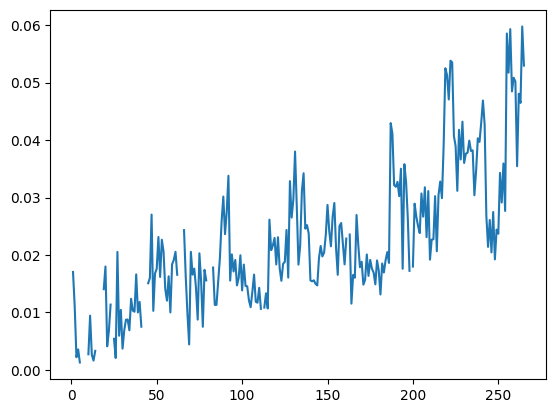

In [34]:
plt.plot(df_tf['inflation'].values)

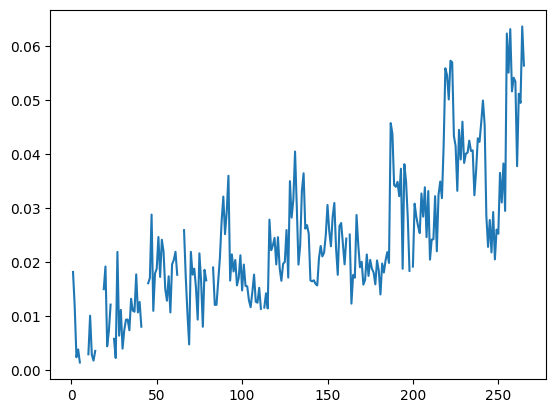

In [35]:
plt.plot(df_tfidf['inflation'].values)

In [36]:
# analyse

In [105]:
infl = pd.read_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))
infl['date'] = infl['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
infl.set_index('date', inplace=True)

In [108]:
lst_terms_all = ['interest', 'inflation', 'energy', 'war', 'credit']
lst_terms_stability = ['stability', 'pressure', 'uncertainty', 'war', 'credit', 'risk']
sub = df_tfidf[lst_terms_all].copy()
sub.index = sub.index.map(dict_dates)
sub.index.name = 'date'

''

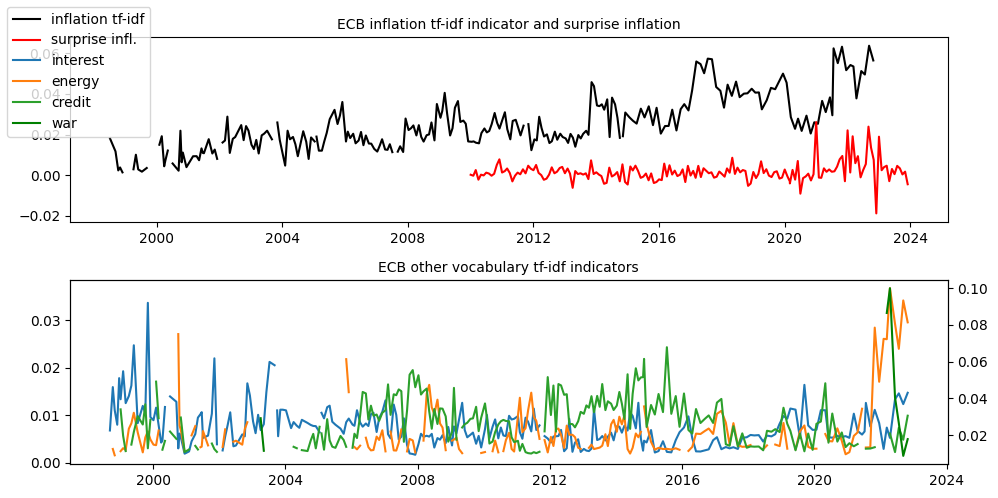

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(sub['inflation'], color='black', label='inflation tf-idf')
ax[0].plot(infl['resid'], color='red', label='surprise infl.')

ax[1].plot(sub.drop(['inflation', 'war'], axis=1), label=sub.drop(['inflation', 'war'], axis=1).columns)
ax[1].twinx().plot(sub['war'], label='war', color='green')

fig.legend(loc='upper left')

ax[0].set_title("ECB inflation tf-idf indicator and surprise inflation", size=10)
ax[1].set_title("ECB other vocabulary tf-idf indicators", size=10)

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph4.png'), )
;
